# LSTMs for Human Activity Recognition

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- squat
- lunge
- walk
- stand

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 



## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import re
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter

import os

/Users/canxiuzhang/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def file_len(fname):
    """
    Get the lines number of a file
    Input:
        - fname: file name
    Output:
        - i+1: number of lines
    """
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i+1

def read_file(fname):
    """
    Read the data of each file
    Input:
        - fname: file name
    Output:
    """
    with open(fname, "r") as f:
        linesNum = file_len(fname)
        lines = f.readlines()
        f.close()

    acc_x, acc_y, acc_z, mag_x, mag_y, mag_z, gyro_x, gyro_y, gyro_z, heel, toe = [np.zeros(linesNum) for i in range(11)]
    
    for i in range (linesNum):
        lineSplit = re.split(',', lines[i]) ### split line by space and store into a list
        for j in range(len(lineSplit)):
            lineSplit[j] = lineSplit[j].strip('[')
            lineSplit[j] = lineSplit[j].strip(']')
            lineSplit[j] = lineSplit[j].strip('\n')
            lineSplit[j] = lineSplit[j].strip(']')
        
        acc_x[i], acc_y[i], acc_z[i], mag_x[i], mag_y[i], mag_z[i], gyro_x[i], gyro_y[i], gyro_z[i], heel[i], toe[i] = lineSplit
    C = np.array([acc_x, acc_y, acc_z, mag_x, mag_y, mag_z, gyro_x, gyro_y, gyro_z, heel, toe])
    
    return np.transpose(C)

def combine_signals(left, right):
    combine = np.concatenate((left, right), axis=1)
    return combine # (1441, 22) / (1200, 22)

def sliding_window(data):
    data_seg = [] 
    i=0
    while (i+2)*10 <= data.shape[0]:
        data_seg.append(data[i*10:(i+2)*10, :])
        i = i+1
    data_seg = np.stack(data_seg, axis=0) 
    return data_seg # (None, 20, 22)

def combine_trails(trail1, trail2):
    combine = np.concatenate((trail1, trail2), axis=0)
    #print(combine.shape)
    return combine # (238, 22)

In [5]:
# collected raw data path
file_path = "/yourpath/dataCollection"

for k in range(1):  # subject
    dirc_path = file_path + '/subject' + str(k+4)
    for j in range(4):  # exercise
        t = []
        path = dirc_path + '/exercise' + str(j+1)
        for i in range(1):  # trail
            x_left = read_file(path + '/trail' + str(i+1) + '_left.txt')
            x_right = read_file(path + '/trail' + str(i+1) + '_right.txt')
            x_combine = combine_signals(x_left, x_right) #(1200, 22)
            #x = sliding_window(x_combine) #(None, 20, 22)
            x = x_combine
            print('after sliding', x.shape)
            if i == 0:
                t = x
            else:
                t = combine_trails(t,x)
        label = np.array([(j,)*t.shape[0]]).reshape(-1,1)
        
        if j==0:
            X = t
            y = label
        else:
            X = combine_trails(X, t)
            y = combine_trails(y, label)
        print(X.shape)

    data_x.append(X)
    data_y.append(y)
    print(len(data_x))
    print(len(data_y))


after sliding (1200, 22)
(1200, 22)
after sliding (1200, 22)
(2400, 22)
after sliding (1200, 22)
(3600, 22)
after sliding (1200, 22)
(4800, 22)
3
3


## 2. Motion completion detection

### 2.1 squat exploration

In [7]:
# index of squat

squat_index = []
for i in range(3):
    indices = [i for i, item in enumerate(data_y[0]) if item == 0]
    squat_index.append(indices)

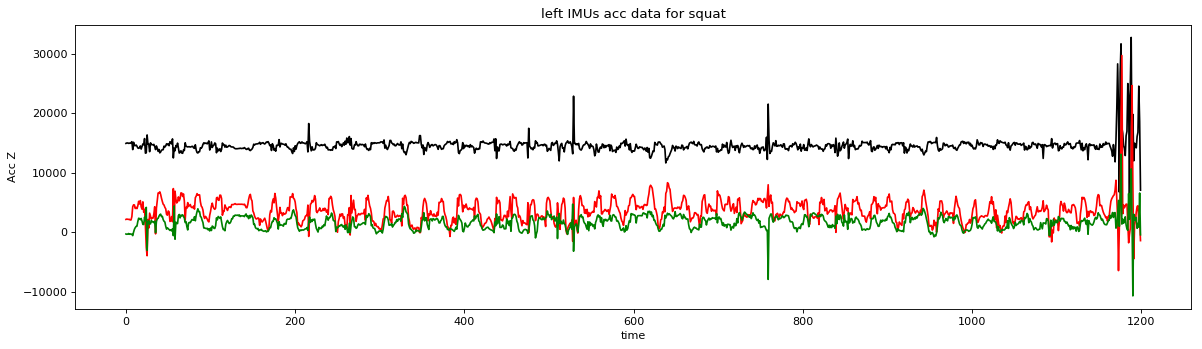

In [8]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,0], 'k-')
plt.title('left IMUs acc data for squat')
plt.ylabel('Acc X')  
plt.plot(t, data_x[0][squat_index[0]][t,1], 'r-')
plt.ylabel('Acc Y')
plt.plot(t, data_x[0][squat_index[0]][t,2], 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time')
plt.show()

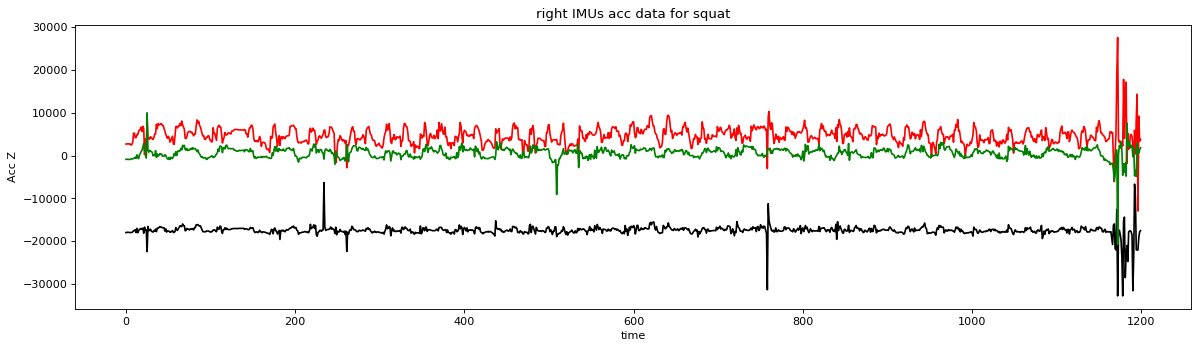

In [9]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,11], 'k-')
plt.title('right IMUs acc data for squat')
plt.ylabel('Acc X')
              
plt.plot(t, data_x[0][squat_index[0]][t,12], 'r-')
plt.ylabel('Acc Y')
plt.plot(t, data_x[0][squat_index[0]][t,13], 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time')
plt.show()

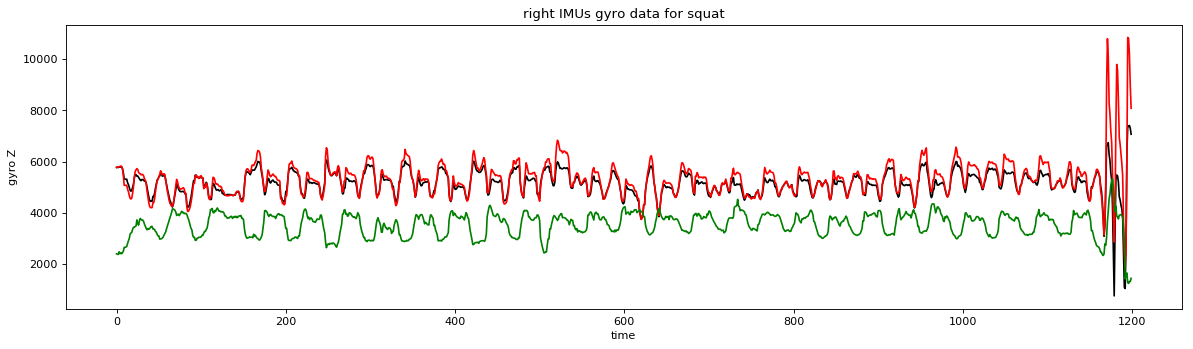

In [21]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,14], 'k-')
plt.title('right IMUs gyro data for squat')
plt.ylabel('gyro X')
              
plt.plot(t, data_x[0][squat_index[0]][t,15], 'r-')
plt.ylabel('gyro Y')
plt.plot(t, data_x[0][squat_index[0]][t,16], 'g-')
plt.ylabel('gyro Z')
plt.xlabel('time')
plt.show()

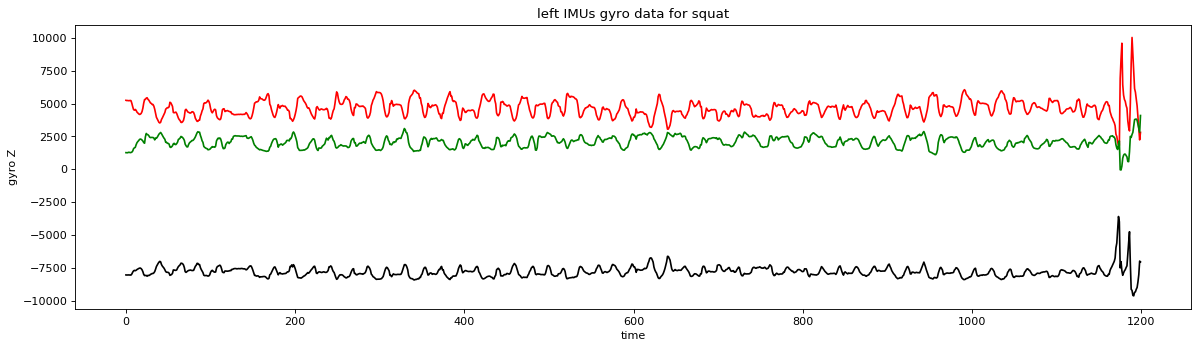

In [22]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,3], 'k-')
plt.title('left IMUs gyro data for squat')
plt.ylabel('gyro X')
              
plt.plot(t, data_x[0][squat_index[0]][t,4], 'r-')
plt.ylabel('gyro Y')
plt.plot(t, data_x[0][squat_index[0]][t,5], 'g-')
plt.ylabel('gyro Z')
plt.xlabel('time')
plt.show()

(1200, 22)


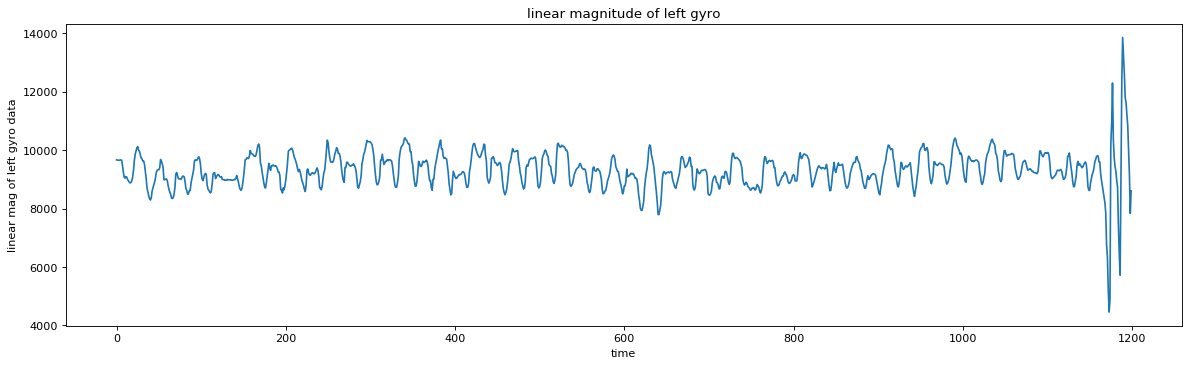

In [25]:
data_s = data_x[0][squat_index[0],:]  # squat data
print(data_s.shape)

gyro_s = np.sqrt(data_s[:,3]**2+data_s[:,4]**2+data_s[:,5]**2)

plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t, gyro_s)
plt.title('linear magnitude of left gyro')
plt.ylabel('linear mag of left gyro data')
plt.xlabel('time')
plt.show()

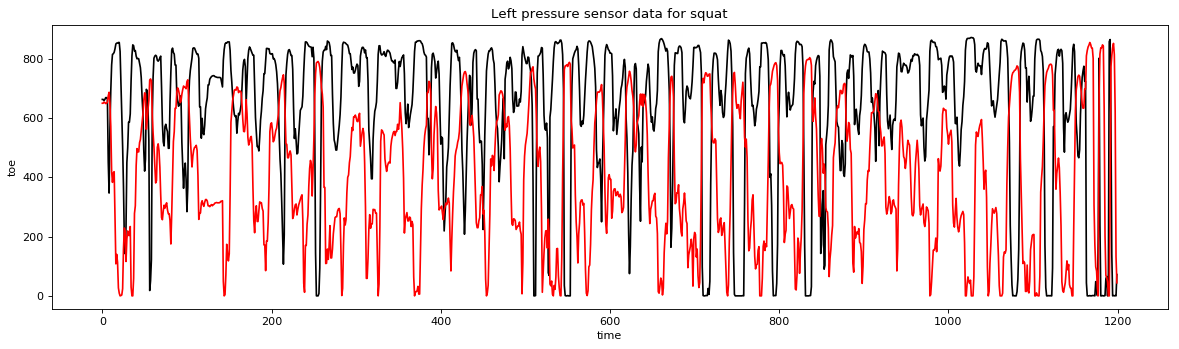

In [10]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,9], 'k-')
plt.title('Left pressure sensor data for squat')
plt.ylabel('heel')
              
plt.plot(t, data_x[0][squat_index[0]][t,10], 'r-')
plt.ylabel('toe')

plt.xlabel('time')
plt.show()

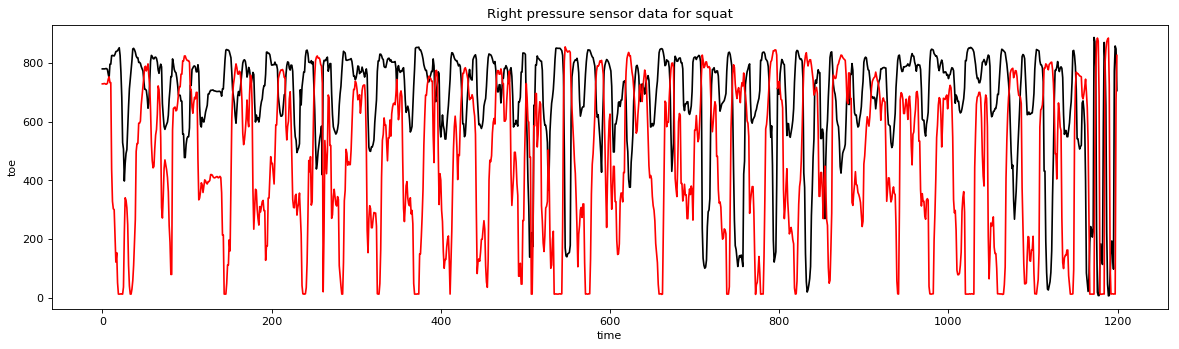

In [11]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_x[0][squat_index[0]][t,20], 'k-')
plt.title('Right pressure sensor data for squat')
plt.ylabel('heel')
              
plt.plot(t, data_x[0][squat_index[0]][t,21], 'r-')
plt.ylabel('toe')

plt.xlabel('time')
plt.show()

In [12]:
# pre-processing for IMU

# high pass filter

def emwfilter(x, a, axis=0):
    """The exponential moving average filter y(n) = (1-a)*x(n)+a*y(n-1)
    INPUT: 
        x -- input time series
        a -- weight
    OUTPUT: 
        y -- filter data
    """
    y = lfilter([1-a], [1, -a], x, axis)
    
    # remove the artifacts at the beginning
    #scale = 1 - np.power(a, np.linspace(1, x.shape[0]+1, x.shape[0])).reshape(x.shape[0],1)
    
    #return y/scale
    return y

# substract gravity

fs = 10
fc_hpf = 0.1
a_emw = np.exp(-2*np.pi*fc_hpf/fs)

# squat data
data_s = data_x[0][squat_index[0],:]  # for subject 1 only
print(data_s.shape)

l_acc_x = data_s[:,0] - emwfilter(data_s[:,0], a_emw)
l_acc_y = data_s[:,1] - emwfilter(data_s[:,1], a_emw)
l_acc_z = data_s[:,2] - emwfilter(data_s[:,2], a_emw)

print(l_acc_x.shape)

(1200, 22)
(1200,)


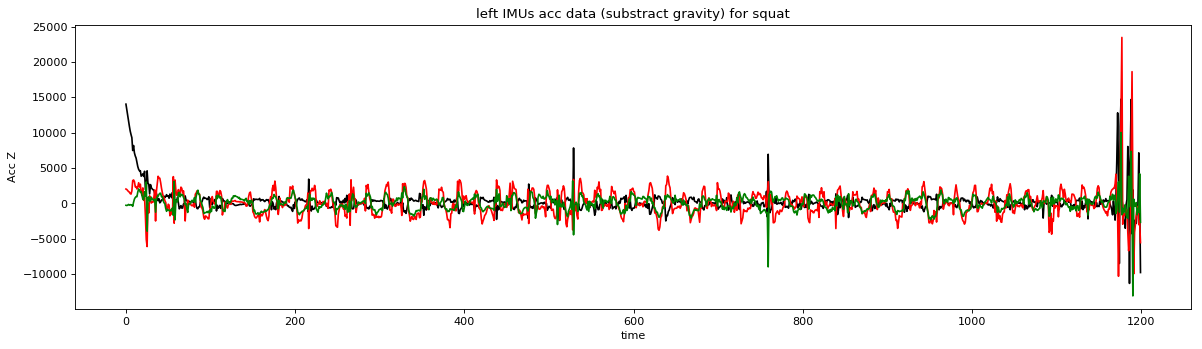

In [13]:
t = np.arange(len(squat_index[0]))
#ind = np.arange(len(t))

plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, l_acc_x, 'k-')
plt.title('left IMUs acc data (substract gravity) for squat')
plt.ylabel('Acc X')  
plt.plot(t, l_acc_y, 'r-')
plt.ylabel('Acc Y')
plt.plot(t, l_acc_z, 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time')
plt.show()

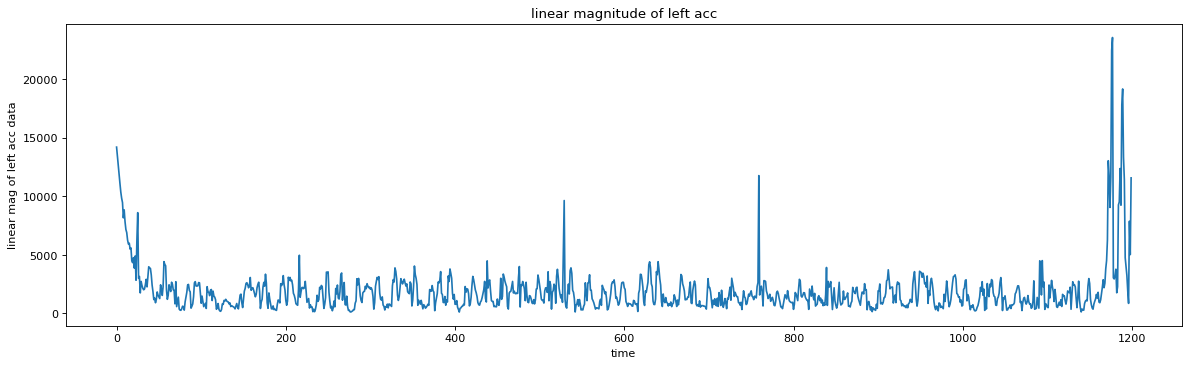

In [14]:
l_acc = np.sqrt(l_acc_x**2+l_acc_y**2+l_acc_z**2)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t, l_acc)
plt.title('linear magnitude of left acc')
plt.ylabel('linear mag of left acc data')
plt.xlabel('time')
plt.show()

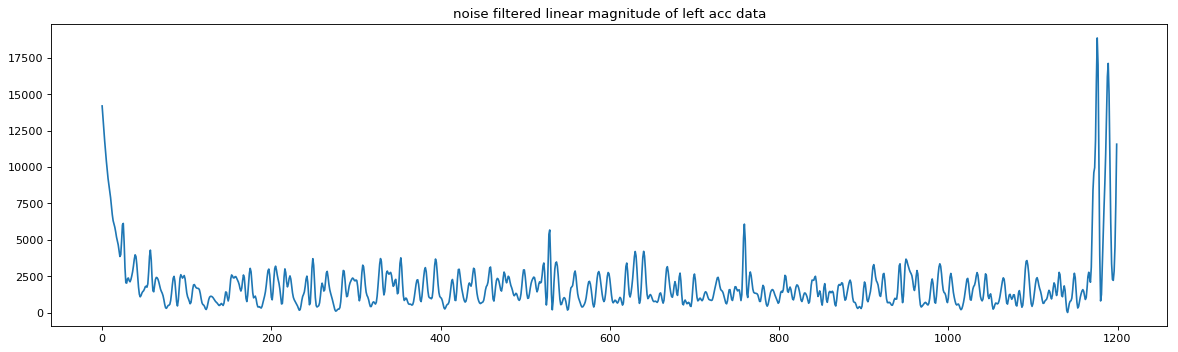

In [15]:
# noise filtering

def butter_lfilter(data, fc, fs, order=5, fb = False):
    """
    Butterworth digital low-pass filter
    Inputs:
        - data: input
        - fc: cutoff freq (Hz)
        - fs: sampling freq (Hz)
        - order: order of the filter (default to 5)
        - fb: forward and backward filter to compensate for the phase shift (default to False)
    Output:
        - filtered data
    """
    nyq = 0.5 * fs
    low = fc / nyq
    b, a = butter(order, low, btype='low')
    if fb:
        y = filtfilt(b, a, data)
    else: 
        y = lfilter(b, a, data)
    
    return y

# parameters for LPF

fc_lpf = 2
l_acc_clean = butter_lfilter(l_acc, fc_lpf, fs, 5, True)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t, l_acc_clean)
plt.title('noise filtered linear magnitude of left acc data')
plt.show()

### 2.2 lunge exploration

In [16]:
# index of lunge

lunge_index = []
for i in range(3):
    indices = [i for i, item in enumerate(data_y[0]) if item == 1]
    lunge_index.append(indices)

(1200, 22)


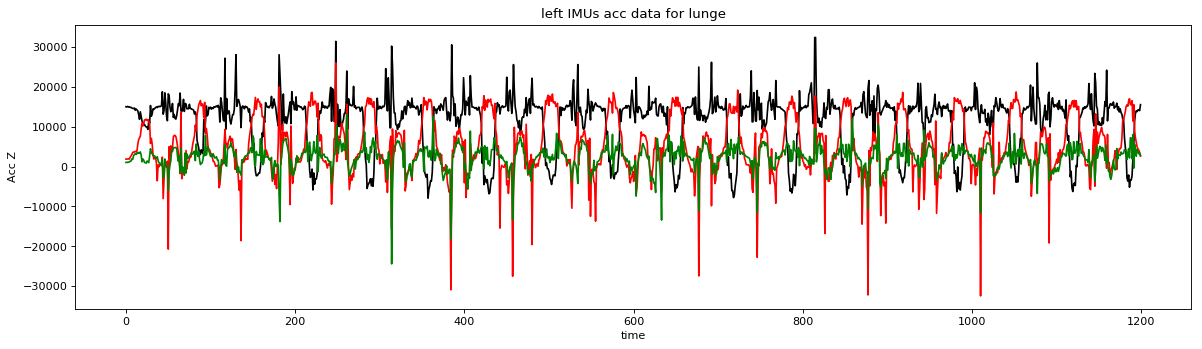

In [17]:
t = np.arange(len(lunge_index[0]))
#ind = np.arange(len(t))

data_l = data_x[0][lunge_index[0],:]  # subject 1 only
print(data_l.shape)
plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_l[:,0], 'k-')
plt.title('left IMUs acc data for lunge')
plt.ylabel('Acc X')  
plt.plot(t, data_l[:,1], 'r-')
plt.ylabel('Acc Y')
plt.plot(t, data_l[:,2], 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time')
plt.show()

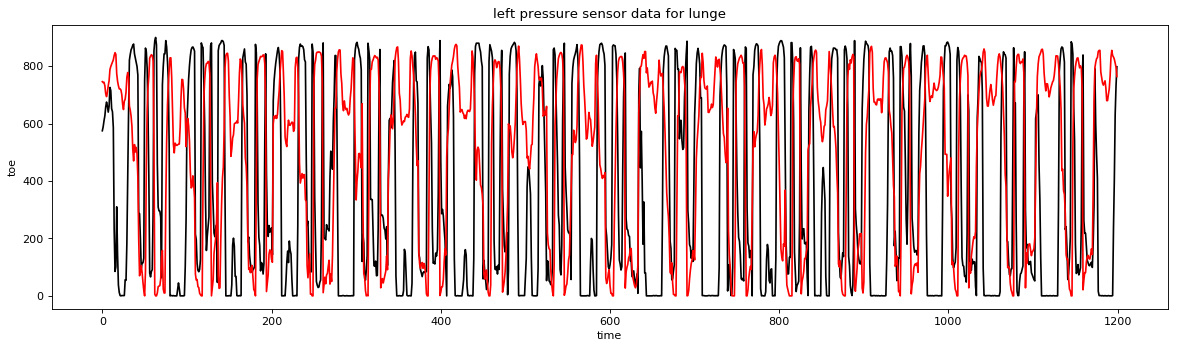

In [18]:
plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(t, data_l[:,9], 'k-')
plt.title('left pressure sensor data for lunge')
plt.ylabel('heel')  
plt.plot(t, data_l[:,10], 'r-')
plt.ylabel('toe')
plt.xlabel('time')
plt.show()

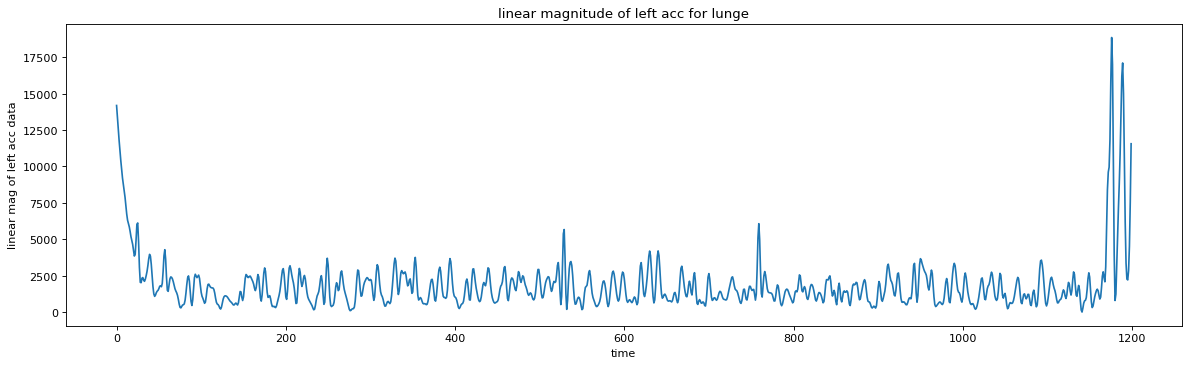

In [34]:
lunge_acc_x = data_l[:,0] - emwfilter(data_l[:,0], a_emw)
lunge_acc_y = data_l[:,1] - emwfilter(data_l[:,1], a_emw)
lunge_acc_z = data_l[:,2] - emwfilter(data_l[:,2], a_emw)
lunge_acc = np.sqrt(lunge_acc_x**2+lunge_acc_y**2+lunge_acc_z**2)
lunge_acc_clean = butter_lfilter(l_acc, fc_lpf, fs, 5, True)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t, lunge_acc_clean)
plt.title('linear magnitude of left acc for lunge')
plt.ylabel('linear mag of left acc data')
plt.xlabel('time')
plt.show()

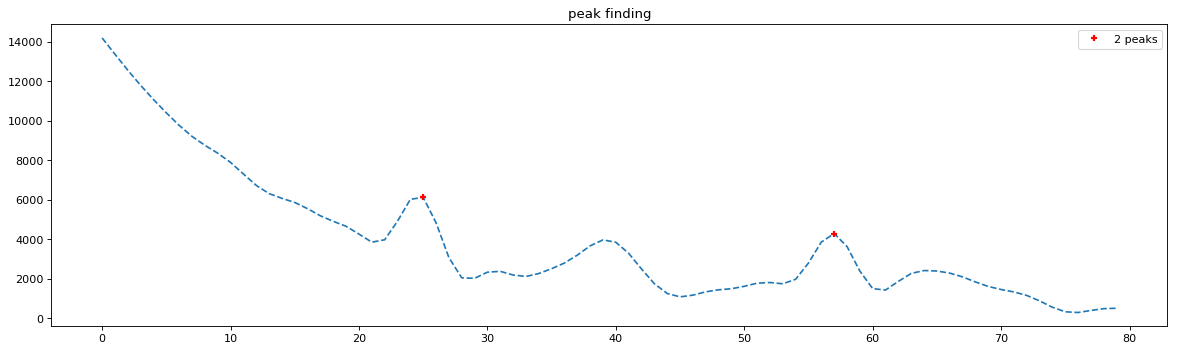

In [32]:
import peakutils
from peakutils.plot import plot as pplot

indexes = peakutils.indexes(lunge_acc_clean[0:80], thres=0.01, min_dist=25)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
pplot(t[0:80], lunge_acc_clean[0:80], indexes)
plt.title('peak finding')
plt.show()

## 3. Sensor comparision

In [6]:
for i in range (3):
    print(data_x[i].shape)
    print(data_y[i].shape)

(476, 20, 22)
(476, 1)
(476, 20, 22)
(476, 1)
(476, 20, 22)
(476, 1)


In [7]:
X_train = combine_trails(data_x[0], data_x[1])
y_train = combine_trails(data_y[0], data_y[1])
X_test = data_x[2]
y_test = data_y[2]
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(952, 20, 22) (952, 1) (476, 20, 22) (476, 1)


In [8]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [9]:
from sklearn import preprocessing
for i in range(X_train.shape[0]):
    X_train[i] = preprocessing.normalize(X_train[i], norm='l2')
for i in range(X_test.shape[0]):
    X_test[i] = preprocessing.normalize(X_test[i], norm='l2')

## left only

In [14]:
X_train_l = X_train[:,:,0:11]
X_test_l = X_test[:,:,0:11]
print(X_train_l.shape)

(952, 20, 11)


## right only

In [16]:
X_train_r = X_train[:,:,11:22]
X_test_r = X_test[:,:,11:22]
print(X_train_r.shape)

(952, 20, 11)


## IMUs only

In [11]:
X_train_imu = X_train
X_train_imu = np.delete(X_train_imu, 9, 2)
X_train_imu = np.delete(X_train_imu, 9, 2)
X_train_imu = np.delete(X_train_imu, 18, 2)
X_train_imu = np.delete(X_train_imu, 18, 2)
print(X_train_imu.shape)

X_test_imu = X_test
X_test_imu = np.delete(X_test_imu, 9, 2)
X_test_imu = np.delete(X_test_imu, 9, 2)
X_test_imu = np.delete(X_test_imu, 18, 2)
X_test_imu = np.delete(X_test_imu, 18, 2)

(952, 20, 18)


## Pressure only

In [19]:
X_train_pre = X_train[:,:,(9,10,20,21)]
print(X_train_imu.shape)

X_test_pre = X_test[:,:,(9,10,20,21)]

(952, 20, 4)


## Motion detection - Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [10]:
# Input Data 

training_data_count = len(X_train)  # 1904 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 952 testing series
n_steps = len(X_train[0])  # 24 timesteps per series
n_input = len(X_train[0][0])  # 22 input parameters per timestep
print('training_data_count', training_data_count)
print('test_data_count', test_data_count)
print('n_steps', n_steps)
print('n_input', n_input)


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 4 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 150
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


training_data_count 952
test_data_count 476
n_steps 20
n_input 22
Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(476, 20, 22) (476, 1) 0.0449932252829 0.208399028628
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [11]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Build the neural network:

In [12]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name='x')
y = tf.placeholder(tf.float32, [None, n_classes], name='y')

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden]), name='weights_hidden'), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0), name='weights_out')
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden]), name='biases_hidden'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='biases_out')
}

pred = tf.nn.softmax(LSTM_RNN(x, weights, biases), name='pred')

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Train the neural network:

In [14]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

Training iter #150:   Batch Loss = 2.250848, Accuracy = 0.13333334028720856
PERFORMANCE ON TEST SET: Batch Loss = 2.2716903686523438, Accuracy = 0.25
Training iter #30000:   Batch Loss = 1.429309, Accuracy = 0.7933333516120911
PERFORMANCE ON TEST SET: Batch Loss = 1.7741336822509766, Accuracy = 0.43697479367256165
Training iter #60000:   Batch Loss = 1.207593, Accuracy = 0.8600000143051147
PERFORMANCE ON TEST SET: Batch Loss = 1.5650686025619507, Accuracy = 0.4663865566253662
Training iter #90000:   Batch Loss = 0.976736, Accuracy = 1.0
PERFORMANCE ON TEST SET: Batch Loss = 1.4867143630981445, Accuracy = 0.4810924232006073
Training iter #120000:   Batch Loss = 0.924972, Accuracy = 0.9933333396911621
PERFORMANCE ON TEST SET: Batch Loss = 1.4373518228530884, Accuracy = 0.4642857015132904
Training iter #150000:   Batch Loss = 0.886195, Accuracy = 1.0
PERFORMANCE ON TEST SET: Batch Loss = 1.3895128965377808, Accuracy = 0.4768907427787781
Training iter #180000:   Batch Loss = 1.023332, Accu

In [16]:
# save the model
saver.save(sess, './LSTM_model_clean')

'./LSTM_model_clean'

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

/Users/canxiuzhang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


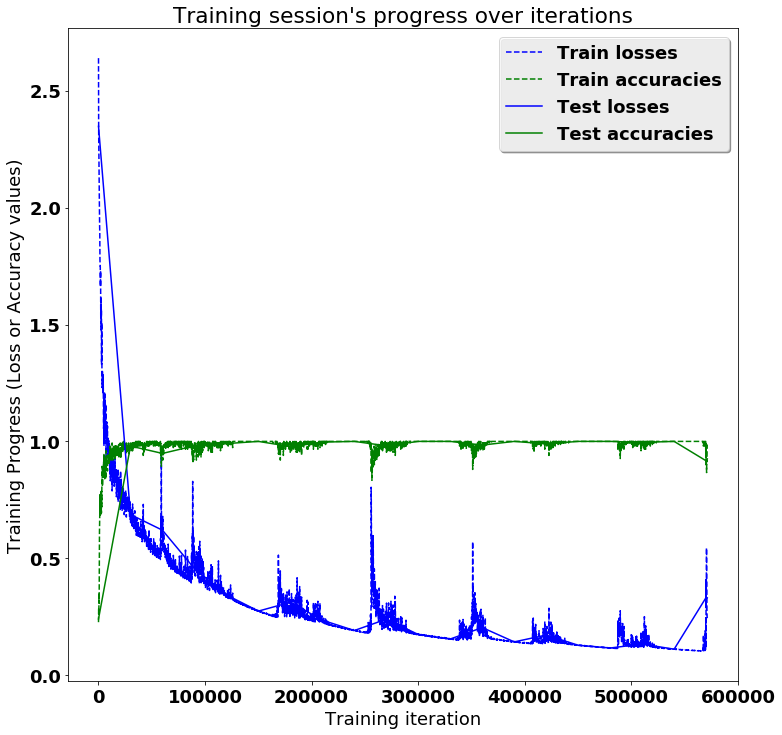

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

In [18]:
sess.close()